In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import zscore

import geopandas as gpd

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

1. Cleaning Taxi-Trips Dataset

In [2]:
full_df = pd.read_csv("Taxi_Trips__2024-__20250505.csv")

In [3]:
full_df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0a11567bd996c51ac32efbb3e60f923c063aabdc,55ef60184d508809c50a84b8c378a8572fcc0f5bd2ff49...,05/01/2025 12:00:00 AM,05/01/2025 12:00:00 AM,291.0,1.27,NaN,NaN,3.0,6.0,...,0.0,6.25,Prcard,Flash Cab,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,122e816a1b04575c94de158252e4e3a544b9f900,52c3ffa685a3b5ced3d16461deec5a0326086bee3d8f6a...,05/01/2025 12:00:00 AM,05/01/2025 12:15:00 AM,1733.0,14.95,NaN,NaN,76.0,3.0,...,4.0,51.90,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
2,181bc2b0347f1364d50dc2312b97f48cd686658a,cf278f6c67e799170264672cf78527e136318d96aefd5f...,05/01/2025 12:00:00 AM,05/01/2025 12:15:00 AM,1319.0,15.05,1.703198e+10,NaN,76.0,NaN,...,26.0,63.75,Credit Card,Taxicab Insurance Agency Llc,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
3,1d17183a28c299443a40163dc3e6d50e10f054f1,d511072131b602026bdb9faa5491d15c3af8d62dc00659...,05/01/2025 12:00:00 AM,05/01/2025 12:00:00 AM,420.0,3.10,NaN,NaN,8.0,32.0,...,0.0,10.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
4,25264cb08e7db926efd88cab3c35d1df4995e11c,c84c28526a906ef1ad0ea7dc570f97949ecf92dfe156cb...,05/01/2025 12:00:00 AM,05/01/2025 12:15:00 AM,882.0,7.72,NaN,NaN,76.0,17.0,...,6.0,27.00,Cash,Globe Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.946511,-87.806020,POINT (-87.8060200025 41.9465114202)


In [5]:
# think about if there are any columns that are not valuable for our case at all
# remove here
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8495661 entries, 0 to 8495660
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Taxi ID                     object 
 2   Trip Start Timestamp        object 
 3   Trip End Timestamp          object 
 4   Trip Seconds                float64
 5   Trip Miles                  float64
 6   Pickup Census Tract         float64
 7   Dropoff Census Tract        float64
 8   Pickup Community Area       float64
 9   Dropoff Community Area      float64
 10  Fare                        float64
 11  Tips                        float64
 12  Tolls                       float64
 13  Extras                      float64
 14  Trip Total                  float64
 15  Payment Type                object 
 16  Company                     object 
 17  Pickup Centroid Latitude    float64
 18  Pickup Centroid Longitude   float64
 19  Pickup Centroid Locat

In [1]:
# we should convert time data into datetime
# change type of Trip_Start_Timestamp and Trip_End_Timestamp to datetime object
full_df["Trip Start Timestamp"] = pd.to_datetime(
    full_df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
)

full_df["Trip End Timestamp"] = pd.to_datetime(
    full_df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
)

NameError: name 'pd' is not defined

In [ ]:
# check for duplicates
n_duplicates = full_df.duplicated().sum()
print(f"Number of duplicate rows: {n_duplicates}")

Number of duplicate rows: 0


In [8]:
# check if any trip ids are duplicate
n_duplicate_trip_ids = full_df["Trip ID"].duplicated().sum()
print(f"Number of duplicated Trip IDs: {n_duplicate_trip_ids}")

Number of duplicated Trip IDs: 0


In [6]:
# check for NA values
# Check for NA values and include relative share
for col in full_df.columns:
    null_count = full_df[col].isna().sum()
    total_rows = len(full_df)
    null_share = (null_count / total_rows) * 100
    print(f'Number of null values in column "{col}": {null_count} ({null_share:.2f}%)')


Number of null values in column "Trip ID": 0 (0.00%)
Number of null values in column "Taxi ID": 3 (0.00%)
Number of null values in column "Trip Start Timestamp": 0 (0.00%)
Number of null values in column "Trip End Timestamp": 72 (0.00%)
Number of null values in column "Trip Seconds": 1631 (0.02%)
Number of null values in column "Trip Miles": 81 (0.00%)
Number of null values in column "Pickup Census Tract": 4844493 (57.02%)
Number of null values in column "Dropoff Census Tract": 4963473 (58.42%)
Number of null values in column "Pickup Community Area": 242728 (2.86%)
Number of null values in column "Dropoff Community Area": 793965 (9.35%)
Number of null values in column "Fare": 21616 (0.25%)
Number of null values in column "Tips": 21616 (0.25%)
Number of null values in column "Tolls": 21616 (0.25%)
Number of null values in column "Extras": 21616 (0.25%)
Number of null values in column "Trip Total": 21616 (0.25%)
Number of null values in column "Payment Type": 0 (0.00%)
Number of null val

In [8]:
# Set the columns to check for NA values (e.g., exclude location columns)
columns_to_remove = ['Taxi ID', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', "Fare", "Tips", "Tolls", "Extras", "Trip Total"]  # change as needed

# Calculate how many rows would be removed if NA in these columns only
removed_na = full_df.shape[0] - full_df.dropna(subset=columns_to_remove).shape[0]
removed_rel_share = (removed_na / full_df.shape[0]) * 100

print(f'Dropping rows with NA in {columns_to_remove} would remove {removed_na} rows ({removed_rel_share:.2f}%) of the dataset.')


Dropping rows with NA in ['Taxi ID', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total'] would remove 22670 rows (0.27%) of the dataset.


We can see that the amount of missing values in these columns are insignificant compared to the entirety of our given data:
- Taxi ID
- Trip End Timestamp
- Trip Seconds
- Trip Miles
- Fare
- Tips
- Tolls
- Extras
- Trip Total

Therefore, we decided to remove them (total: 0.18%).

In [9]:
# remove na in taxiID
full_df = full_df.dropna(subset=columns_to_remove)

In [10]:
# TODO: exclude the location based columns
removed_na = full_df.shape[0] - full_df.dropna().shape[0]
removed_rel_share = (removed_na / full_df.shape[0]) * 100
print(f'Dropping all rows with any NA values would remove {removed_na} rows ({removed_rel_share:.2f}%) of the dataset.')


Dropping all rows with any NA values would remove 5025501 rows (59.31%) of the dataset.


TODO: decide what to do with the NA-values. Check how many rows would be deleted if we were to just delete all NA values and if it is feasible, delete them.

# 1.2 Trip Data

In [11]:
# trip miles > 0
n_negative_miles = (full_df["Trip Miles"] <= 0).sum()
print(f"Number of incorrect trip miles: {n_negative_miles}")

Number of incorrect trip miles: 809182


In [12]:
# trip seconds < 60 (s)
n_seconds_less_min = (full_df["Trip Seconds"] < 60).sum()
print(f"Number of trips faster than 1 min: {n_seconds_less_min}")

Number of trips faster than 1 min: 470405


In [13]:
# remove negative trip miles and trips faster than 60s
full_df = full_df[((full_df["Trip Miles"] > 0) & (full_df["Trip Seconds"] >= 60))]

In [14]:
# check: every taxi can only do one task at a time, so the same taxi id cannot have multiple overlapping driving time periods

overlapping_trips = full_df.groupby('Taxi ID').apply(
    lambda group: group[
        (group['Trip Start Timestamp'].lt(group['Trip End Timestamp'].shift(-1))) &
        (group['Trip End Timestamp'].gt(group['Trip Start Timestamp'].shift(-1)))
    ]
)
print("Number of Taxi IDs with overlapping operation time periods:", len(overlapping_trips))
overlapping_trips

Number of Taxi IDs with overlapping operation time periods: 31489


/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_68527/968962904.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlapping_trips = full_df.groupby('Taxi ID').apply(


Trip ID  \
Taxi ID                                                                                                
0041f8f0c91881c1e1913f2548522495fe3c4c719aa67fd... 3965549  1cd48bb6534a5ef5b80bc0b7cd15eca1176a2fd0   
                                                   4002327  9b7646c1d4926b3e4075e28b27d29eb2bc450ef0   
                                                   4025417  b1e3e90887c39c370df4eba37a38535807ed1dd0   
                                                   4048522  db27e7fa373aba6577222440448c2198157d3361   
                                                   4053728  f412ee714da452071d33d62cfc162710c2e63e92   
...                                                                                              ...   
ff5a3bcec871b7dd99b5eb851c17f4198eec9e3d4d1ecea... 2836431  fa75ae58f5a071e0d7eb8e872cf5e3b3c57508e9   
                                                   2984080  7d445adefbbc1ebf2cf1d4110e1331cee252d5e9   
                                                   3048796  9224417803ca81f64c2d98221b527c0aeac45507   
                                                   5941838  7cf8ed8a2e15cc0359cedc6aa31191f3c16a57e5   
ff650cbcf1ba62caac94578e2e96316c742818a3bcf4acb... 7173819  c6c795b9fd6eabea56c56daac34084bebfe6e6da   

                                                                                                      Taxi ID  \
Taxi ID                                                                                                         
0041f8f0c91881c1e1913f2548522495fe3c4c719aa67fd... 3965549  0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...   
                                                   4002327  0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...   
                                                   4025417  0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...   
                                                   4048522  0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...   
                                                   4053728  0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...   
...                                                                                                       ...   
ff5a3bcec871b7dd99b5eb851c17f4198eec9e3d4d1ecea... 2836431  ff5a3bcec871b7dd99b5eb851c17f4198eec9e3d4d1ece...   
                                                   2984080  ff5a3bcec871b7dd99b5eb851c17f4198eec9e3d4d1ece...   
                                                   3048796  ff5a3bcec871b7dd99b5eb851c17f4198eec9e3d4d1ece...   
                                                   5941838  ff5a3bcec871b7dd99b5eb851c17f4198eec9e3d4d1ece...   
ff650cbcf1ba62caac94578e2e96316c742818a3bcf4acb... 7173819  ff650cbcf1ba62caac94578e2e96316c742818a3bcf4ac...   

                                                           Trip Start Timestamp  \
Taxi ID                                                                           
0041f8f0c91881c1e1913f2548522495fe3c4c719aa67fd... 3965549  2024-09-15 07:45:00   
                                                   4002327  2024-09-12 22:00:00   
                                                   4025417  2024-09-11 22:15:00   
                                                   4048522  2024-09-10 22:00:00   
                                                   4053728  2024-09-10 17:30:00   
...                                                                         ...   
ff5a3bcec871b7dd99b5eb851c17f4198eec9e3d4d1ecea... 2836431  2024-11-13 08:00:00   
                                                   2984080  2024-11-05 09:00:00   
                                                   3048796  2024-11-01 15:30:00   
                                                   5941838  2024-05-31 21:45:00   
ff650cbcf1ba62caac94578e2e96316c742818a3bcf4acb... 7173819  2024-03-27 16:30:00   

                                                            Trip End Timestamp  \
Taxi ID                                                                          
0041f8f0c91881c1e1913f2548

In [15]:
# assumption: if there are overlapping trips with the same taxi id, there was something wrong with all of these trips, so therefore we remove all of the overlapping trips
overlapping_trips_indices = overlapping_trips.index.get_level_values(1)
full_df = full_df.drop(overlapping_trips_indices, axis= 0)
full_df.reset_index(drop = True)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0a11567bd996c51ac32efbb3e60f923c063aabdc,55ef60184d508809c50a84b8c378a8572fcc0f5bd2ff49...,2025-05-01,2025-05-01 00:00:00,291.0,1.27,NaN,NaN,3.0,6.0,...,0.0,6.25,Prcard,Flash Cab,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,122e816a1b04575c94de158252e4e3a544b9f900,52c3ffa685a3b5ced3d16461deec5a0326086bee3d8f6a...,2025-05-01,2025-05-01 00:15:00,1733.0,14.95,NaN,NaN,76.0,3.0,...,4.0,51.90,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
2,181bc2b0347f1364d50dc2312b97f48cd686658a,cf278f6c67e799170264672cf78527e136318d96aefd5f...,2025-05-01,2025-05-01 00:15:00,1319.0,15.05,1.703198e+10,NaN,76.0,NaN,...,26.0,63.75,Credit Card,Taxicab Insurance Agency Llc,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
3,1d17183a28c299443a40163dc3e6d50e10f054f1,d511072131b602026bdb9faa5491d15c3af8d62dc00659...,2025-05-01,2025-05-01 00:00:00,420.0,3.10,NaN,NaN,8.0,32.0,...,0.0,10.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
4,25264cb08e7db926efd88cab3c35d1df4995e11c,c84c28526a906ef1ad0ea7dc570f97949ecf92dfe156cb...,2025-05-01,2025-05-01 00:15:00,882.0,7.72,NaN,NaN,76.0,17.0,...,6.0,27.00,Cash,Globe Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.946511,-87.806020,POINT (-87.8060200025 41.9465114202)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545420,ee8183d28c6fd24ba14efc85fedb582e7315db8d,d6e1a9e103336c396201abe9ceb00795fcd41e14ccbf54...,2024-01-01,2024-01-01 00:00:00,218.0,0.80,NaN,NaN,28.0,32.0,...,1.5,10.25,Credit Card,Flash Cab,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
7545421,f031add069e7eecdb4489e8a6ec8f65f6e1a8362,bcda8c3cc4c7917b5e59fdbda4a08b57312fd55f6cb3cf...,2024-01-01,2024-01-01 00:15:00,1034.0,7.79,NaN,NaN,76.0,NaN,...,3.0,24.75,Cash,Star North Taxi Management Llc,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
7545422,f75d3bbd97819a0d504965d228082afbd9c2423b,913c95ba782fa447b7c55fbfc38d040907d13e7ddf7282...,2024-01-01,2024-01-01 00:30:00,1752.0,1.53,NaN,NaN,32.0,8.0,...,0.0,13.50,Cash,Flash Cab,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
7545423,f7846f50726d0db826cafcf098de8f4e8f36f1a5,6ac56232b10298edfb36d568c8f7e71db5a741c2f31c81...,2024-01-01,2024-01-01 00:15:00,378.0,0.17,NaN,NaN,6.0,6.0,...,1.0,6.25,Cash,Sun Taxi,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)


# 1.3 Price Data

In [17]:
# check for prices <= 0
# since tips, tolls and extras are dependent on the details of the trips and might be 0, it is okay for them to be 0.
# Fares are mandatory and have to be greater than 0

fare_check = (full_df['Fare'] <= 0).sum()
tips_check = (full_df['Tips'] < 0).sum()
tolls_check = (full_df['Tolls'] < 0).sum()
extras_check = (full_df['Extras'] < 0).sum()
print("Number of entries with fares <= 0:", fare_check)
print("Number of entries with tips <= 0:", tips_check)
print("Number of entries with tolls <= 0:", tolls_check)
print("Number of entries with extras <= 0:", extras_check)

Number of entries with fares <= 0: 1944
Number of entries with tips <= 0: 0
Number of entries with tolls <= 0: 0
Number of entries with extras <= 0: 0


In [18]:
# remove negative or 0 fares
full_df = full_df[full_df["Fare"] > 0]
full_df.reset_index(drop=True)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0a11567bd996c51ac32efbb3e60f923c063aabdc,55ef60184d508809c50a84b8c378a8572fcc0f5bd2ff49...,2025-05-01,2025-05-01 00:00:00,291.0,1.27,NaN,NaN,3.0,6.0,...,0.0,6.25,Prcard,Flash Cab,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,122e816a1b04575c94de158252e4e3a544b9f900,52c3ffa685a3b5ced3d16461deec5a0326086bee3d8f6a...,2025-05-01,2025-05-01 00:15:00,1733.0,14.95,NaN,NaN,76.0,3.0,...,4.0,51.90,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
2,181bc2b0347f1364d50dc2312b97f48cd686658a,cf278f6c67e799170264672cf78527e136318d96aefd5f...,2025-05-01,2025-05-01 00:15:00,1319.0,15.05,1.703198e+10,NaN,76.0,NaN,...,26.0,63.75,Credit Card,Taxicab Insurance Agency Llc,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
3,1d17183a28c299443a40163dc3e6d50e10f054f1,d511072131b602026bdb9faa5491d15c3af8d62dc00659...,2025-05-01,2025-05-01 00:00:00,420.0,3.10,NaN,NaN,8.0,32.0,...,0.0,10.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
4,25264cb08e7db926efd88cab3c35d1df4995e11c,c84c28526a906ef1ad0ea7dc570f97949ecf92dfe156cb...,2025-05-01,2025-05-01 00:15:00,882.0,7.72,NaN,NaN,76.0,17.0,...,6.0,27.00,Cash,Globe Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.946511,-87.806020,POINT (-87.8060200025 41.9465114202)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543476,ee8183d28c6fd24ba14efc85fedb582e7315db8d,d6e1a9e103336c396201abe9ceb00795fcd41e14ccbf54...,2024-01-01,2024-01-01 00:00:00,218.0,0.80,NaN,NaN,28.0,32.0,...,1.5,10.25,Credit Card,Flash Cab,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
7543477,f031add069e7eecdb4489e8a6ec8f65f6e1a8362,bcda8c3cc4c7917b5e59fdbda4a08b57312fd55f6cb3cf...,2024-01-01,2024-01-01 00:15:00,1034.0,7.79,NaN,NaN,76.0,NaN,...,3.0,24.75,Cash,Star North Taxi Management Llc,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
7543478,f75d3bbd97819a0d504965d228082afbd9c2423b,913c95ba782fa447b7c55fbfc38d040907d13e7ddf7282...,2024-01-01,2024-01-01 00:30:00,1752.0,1.53,NaN,NaN,32.0,8.0,...,0.0,13.50,Cash,Flash Cab,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
7543479,f7846f50726d0db826cafcf098de8f4e8f36f1a5,6ac56232b10298edfb36d568c8f7e71db5a741c2f31c81...,2024-01-01,2024-01-01 00:15:00,378.0,0.17,NaN,NaN,6.0,6.0,...,1.0,6.25,Cash,Sun Taxi,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)


# 1.4 Feature Engineering

In [19]:
# Calculate trip duration in seconds
full_df['Trip Duration'] = (full_df['Trip End Timestamp'] - full_df['Trip Start Timestamp']).dt.total_seconds()

# 1.5 Outlier Detection

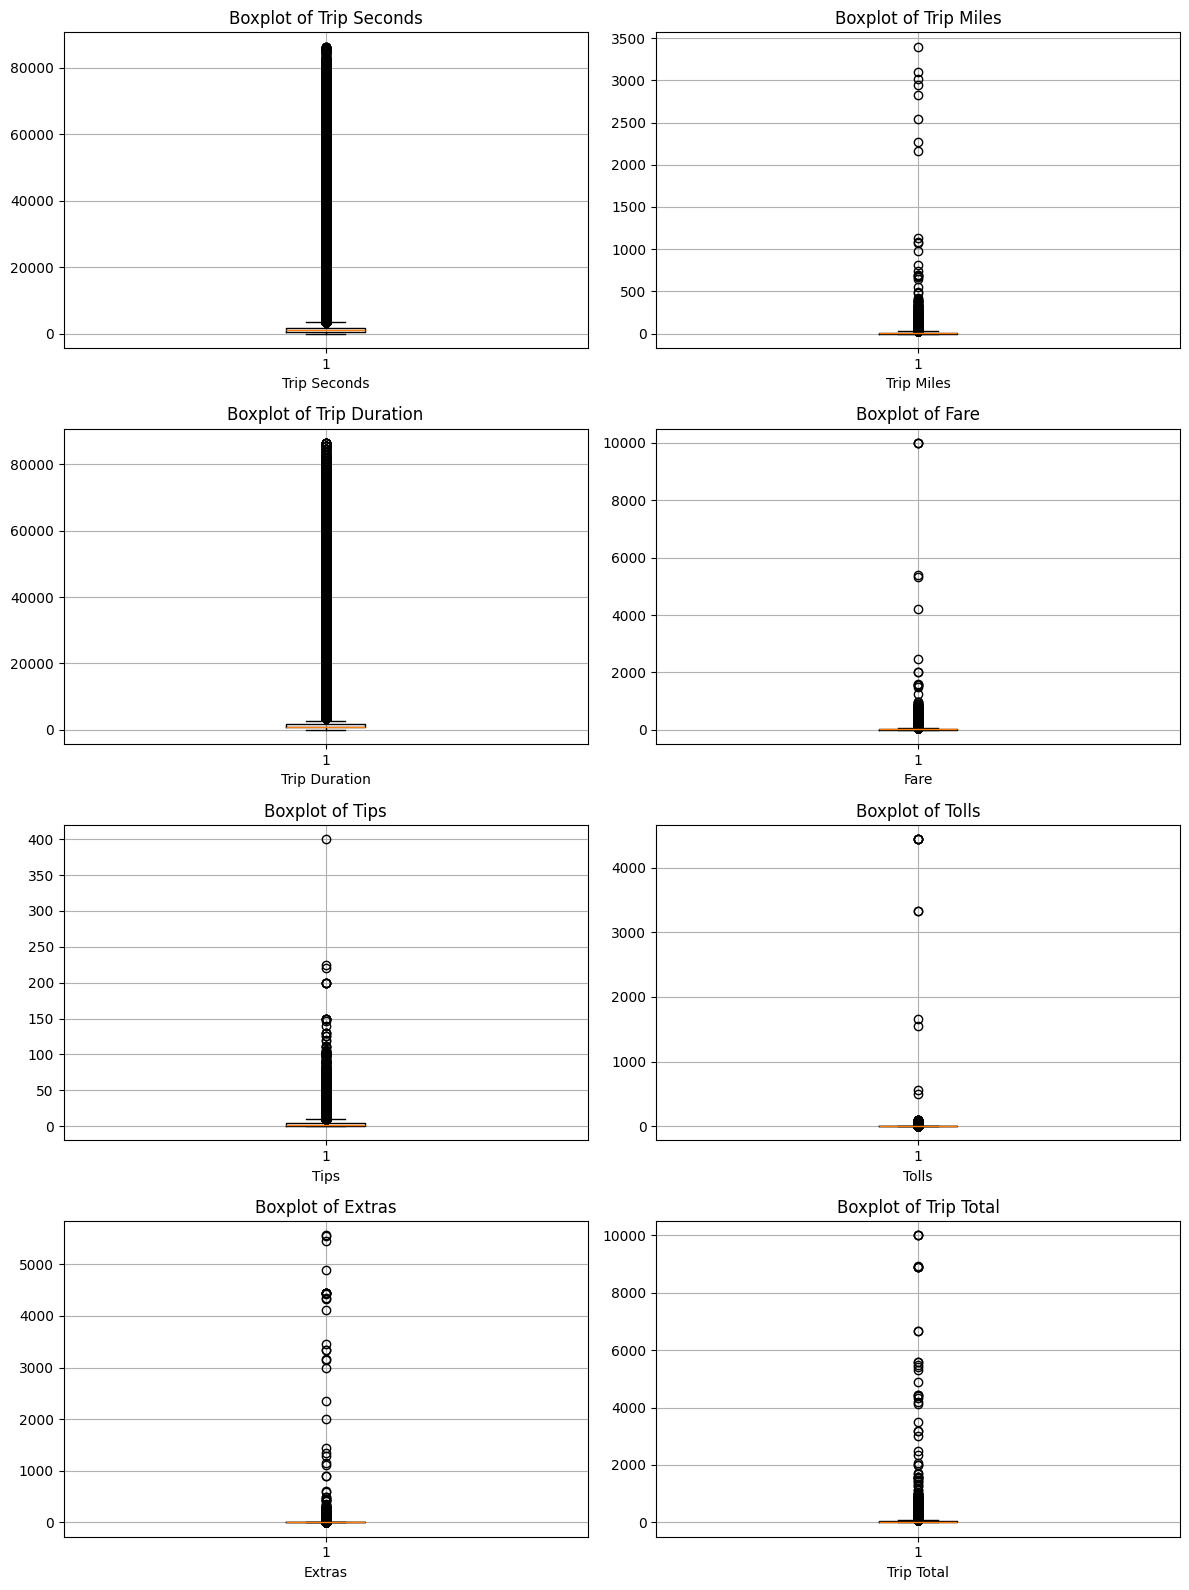

In [ ]:
numeric_columns = ["Trip Seconds", "Trip Miles", "Trip Duration", "Fare", "Tips", "Tolls", "Extras", "Trip Total"]

# 2 plots per row
rows = math.ceil(len(numeric_columns) / 2)

fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    data = pd.to_numeric(full_df[col], errors='coerce').dropna()
    axes[i].boxplot(data, vert=True)
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].grid(True)

# Remove any unused axes
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [31]:
zscore_threshold = 2
outlier_indices_per_column = {}
all_outlier_indices = set()

# remove outliers based on z-score
for col in numeric_columns:
    # Replace zeros with NaN and filter out non-positive values
    safe_col = full_df[col].replace(0, np.nan)
    safe_col = safe_col[safe_col > 0]
    
    if safe_col.empty:
        continue
    
    # Log-transform and compute z-score
    log_transformed = np.log(safe_col)
    zscores = np.abs(zscore(log_transformed))
    zscore_series = pd.Series(zscores, index=log_transformed.index)

    # Find outliers
    outlier_indices = zscore_series[zscore_series > zscore_threshold].index
    outlier_indices_per_column[col] = list(outlier_indices)
    all_outlier_indices.update(outlier_indices)

    print(f"--> {len(outlier_indices)} outliers detected in '{col}'")

# Drop all outliers at once
df_cleaned = full_df.drop(index=all_outlier_indices).reset_index(drop=True)
print(f"\nOutlier detection completed. Total rows removed: {len(all_outlier_indices)}")

--> 250478 outliers detected in 'Trip Seconds'
--> 137272 outliers detected in 'Trip Miles'
--> 153549 outliers detected in 'Trip Duration'
--> 48183 outliers detected in 'Fare'
--> 64403 outliers detected in 'Tips'
--> 2662 outliers detected in 'Tolls'
--> 187104 outliers detected in 'Extras'
--> 95914 outliers detected in 'Trip Total'

Outlier detection completed. Total rows removed: 656351


# 1.6 Location Data Cleanup

In [ ]:
tracts  = gpd.read_file("tl_2024_17_tract.geojson").to_crs(4326)

tract_centroids = (tracts.set_index("GEOID").geometry.centroid)

# checking for rows with coordinates and without tracts, to infer tracts
pickup_missing_tract = (full_df["Pickup Census Tract"].isna()
                 & full_df["Pickup Centroid Latitude"].notna()
                 & full_df["Pickup Centroid Longitude"].notna()
)


dropoff_missing_tract = (full_df["Dropoff Census Tract"].isna()
                 & full_df["Dropoff Centroid Latitude"].notna()
                 & full_df["Dropoff Centroid Longitude"].notna()
)

if pickup_missing_tract.any():
    pickup_points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            full_df.loc[pickup_missing_tract, "Pickup Centroid Longitude"],
            full_df.loc[pickup_missing_tract, "Pickup Centroid Latitude"],
            crs=4326
        ),
        index=full_df.index[pickup_missing_tract]
    )

if dropoff_missing_tract.any():
    dropoff_points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            full_df.loc[dropoff_missing_tract, "Dropoff Centroid Longitude"],
            full_df.loc[dropoff_missing_tract, "Dropoff Centroid Latitude"],
            crs=4326
        ),
        index=full_df.index[dropoff_missing_tract]
    )


pickup_joined = gpd.sjoin(pickup_points, tracts[["GEOID", "geometry"]], how="left", predicate="within")
full_df.loc[pickup_joined.index, "Pickup Census Tract"] = pickup_joined["GEOID"].values

dropoff_joined = gpd.sjoin(dropoff_points, tracts[["GEOID", "geometry"]], how="left", predicate="within")
full_df.loc[dropoff_joined.index, "Dropoff Census Tract"] = dropoff_joined["GEOID"].values

#checking for any rows with tracts and without coordinates and setting coordinates to center point of tract

pickup_missing_coords = (
    full_df["Pickup Census Tract"].notna()
    & full_df["Pickup Centroid Latitude"].isna()
    & full_df["Pickup Centroid Longitude"].isna()
)

dropoff_missing_coords = (
    full_df["Dropoff Census Tract"].notna()
    & full_df["Dropoff Centroid Latitude"].isna()
    & full_df["Dropoff Centroid Longitude"].isna()
)

if pickup_missing_coords.any():
    cent = tract_centroids.reindex(full_df.loc[pickup_missing_coords, "Pickup Census Tract"].astype(str))
    full_df.loc[pickup_missing_coords, "Pickup Centroid Latitude"] = cent.y.values
    full_df.loc[pickup_missing_coords, "Pickup Centroid Longitude"] = cent.x.values

if dropoff_missing_coords.any():
    cent = tract_centroids.reindex(full_df.loc[dropoff_missing_coords, "Dropoff Census Tract"].astype(str))
    full_df.loc[dropoff_missing_coords, "Dropoff Centroid Latitude"] = cent.y.values
    full_df.loc[dropoff_missing_coords, "Dropoff Centroid Longitude"] = cent.x.values


print(full_df.isnull().sum())


In [ ]:
full_df = full_df.dropna(subset=['Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Dropoff Census Tract', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])
print(full_df.isnull().sum())

In [ ]:
# store cleaned dataset in .csv
full_df.to_csv("Chicago_Trips.csv", index=False)